#Building and Comparing Machine Learning Models for Predicting Alphabet Soup-Funded Organization Success

**Overview of the Analysis**

The primary objective of this analysis is to develop a predictive model using machine learning techniques to determine whether an organization funded by Alphabet Soup will be successful. Leveraging the charity_data.csv dataset, we aimed to preprocess the data, identify the most significant features, and build various machine learning models capable of achieving a predictive accuracy exceeding 90%. By comparing different models and optimizing their hyperparameters, we seek to identify the most effective approach for this classification task.

In [1]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel

# Handling class imbalance
from imblearn.over_sampling import SMOTE

# XGBoost
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the dataset
data_url = "https://static.bc-edx.com/data/dla-1-2/m21/lms/starter/charity_data.csv"
application_df = pd.read_csv(data_url)

# Display the first five rows
print("First five rows of the dataset:")
print(application_df.head())

# Display dataset information
print("\nDataset Information:")
print(application_df.info())

# Display summary statistics
print("\nSummary Statistics:")
print(application_df.describe())


First five rows of the dataset:
        EIN                                      NAME APPLICATION_TYPE  \
0  10520599              BLUE KNIGHTS MOTORCYCLE CLUB              T10   
1  10531628    AMERICAN CHESAPEAKE CLUB CHARITABLE TR               T3   
2  10547893        ST CLOUD PROFESSIONAL FIREFIGHTERS               T5   
3  10553066            SOUTHSIDE ATHLETIC ASSOCIATION               T3   
4  10556103  GENETIC RESEARCH INSTITUTE OF THE DESERT               T3   

        AFFILIATION CLASSIFICATION      USE_CASE  ORGANIZATION  STATUS  \
0       Independent          C1000    ProductDev   Association       1   
1       Independent          C2000  Preservation  Co-operative       1   
2  CompanySponsored          C3000    ProductDev   Association       1   
3  CompanySponsored          C2000  Preservation         Trust       1   
4       Independent          C1000     Heathcare         Trust       1   

      INCOME_AMT SPECIAL_CONSIDERATIONS  ASK_AMT  IS_SUCCESSFUL  
0           

In [3]:
# Drop 'EIN' and 'NAME' columns
application_df = application_df.drop(['EIN', 'NAME'], axis=1)
print("\nColumns after dropping 'EIN' and 'NAME':")
print(application_df.columns)



Columns after dropping 'EIN' and 'NAME':
Index(['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE',
       'ORGANIZATION', 'STATUS', 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS',
       'ASK_AMT', 'IS_SUCCESSFUL'],
      dtype='object')


In [4]:
# Identify categorical columns
categorical_cols = application_df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Columns:", categorical_cols)

# One-hot encode categorical variables
application_df_encoded = pd.get_dummies(application_df, columns=categorical_cols, drop_first=True)
print("\nDataFrame shape after one-hot encoding:", application_df_encoded.shape)




Categorical Columns: ['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE', 'ORGANIZATION', 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS']

DataFrame shape after one-hot encoding: (34299, 110)


In [5]:
# Check for missing values
print("\nMissing values in each column:")
print(application_df_encoded.isnull().sum())

# Identify numerical and categorical columns after encoding
numerical_cols = application_df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = application_df_encoded.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    print("\nCategorical columns after encoding:", categorical_cols)
else:
    print("\nNo categorical columns left after encoding.")

# Impute numerical columns if there are missing values
if application_df_encoded[numerical_cols].isnull().sum().sum() > 0:
    imputer_num = SimpleImputer(strategy='median')
    application_df_encoded[numerical_cols] = imputer_num.fit_transform(application_df_encoded[numerical_cols])
    print("\nMissing values after imputation:")
    print(application_df_encoded.isnull().sum())
else:
    print("\nNo missing values found in the dataset.")


Missing values in each column:
STATUS                      0
ASK_AMT                     0
IS_SUCCESSFUL               0
APPLICATION_TYPE_T12        0
APPLICATION_TYPE_T13        0
                           ..
INCOME_AMT_1M-5M            0
INCOME_AMT_25000-99999      0
INCOME_AMT_50M+             0
INCOME_AMT_5M-10M           0
SPECIAL_CONSIDERATIONS_Y    0
Length: 110, dtype: int64

No categorical columns left after encoding.

No missing values found in the dataset.


In [6]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Identify feature columns (all columns except the target)
feature_cols = application_df_encoded.drop('IS_SUCCESSFUL', axis=1).columns.tolist()

# Scale the features
application_df_encoded[feature_cols] = scaler.fit_transform(application_df_encoded[feature_cols])

print("\nFeatures after scaling:")
print(application_df_encoded[feature_cols].head())



Features after scaling:
     STATUS   ASK_AMT  APPLICATION_TYPE_T12  APPLICATION_TYPE_T13  \
0  0.012075 -0.031725             -0.028068             -0.043909   
1  0.012075 -0.030536             -0.028068             -0.043909   
2  0.012075 -0.031725             -0.028068             -0.043909   
3  0.012075 -0.031706             -0.028068             -0.043909   
4  0.012075 -0.030146             -0.028068             -0.043909   

   APPLICATION_TYPE_T14  APPLICATION_TYPE_T15  APPLICATION_TYPE_T17  \
0             -0.009353             -0.007636               -0.0054   
1             -0.009353             -0.007636               -0.0054   
2             -0.009353             -0.007636               -0.0054   
3             -0.009353             -0.007636               -0.0054   
4             -0.009353             -0.007636               -0.0054   

   APPLICATION_TYPE_T19  APPLICATION_TYPE_T2  APPLICATION_TYPE_T25  ...  \
0             -0.179013            -0.021603             -

In [7]:
# Check class distribution
class_counts = application_df_encoded['IS_SUCCESSFUL'].value_counts()
print("\nClass Distribution:")
print(class_counts)

# Calculate the imbalance ratio
imbalance_ratio = class_counts.min() / class_counts.max()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")

# Apply SMOTE if imbalance ratio is less than 0.5
if imbalance_ratio < 0.5:
    print("\nApplying SMOTE to balance the classes...")
    smote = SMOTE(random_state=42)
    X = application_df_encoded.drop('IS_SUCCESSFUL', axis=1)
    y = application_df_encoded['IS_SUCCESSFUL']
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("Class distribution after SMOTE:")
    print(pd.Series(y_resampled).value_counts())
else:
    print("\nNo significant class imbalance detected. Proceeding without SMOTE.")
    X_resampled = application_df_encoded.drop('IS_SUCCESSFUL', axis=1)
    y_resampled = application_df_encoded['IS_SUCCESSFUL']



Class Distribution:
IS_SUCCESSFUL
1    18261
0    16038
Name: count, dtype: int64

Imbalance Ratio: 0.88

No significant class imbalance detected. Proceeding without SMOTE.


In [8]:
# Train a RandomForest model to get feature importances
rf_feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selector.fit(X_resampled, y_resampled)

# Get feature importances
importances = rf_feature_selector.feature_importances_

# Create a list of tuples (importance, feature name)
feature_importances = sorted(zip(importances, X_resampled.columns), reverse=True)

# Display the sorted features
print("\nTop 20 Important Features:")
for importance, feature in feature_importances[:20]:
    print(f"Feature: {feature}, Importance: {importance:.4f}")



Top 20 Important Features:
Feature: ASK_AMT, Importance: 0.4007
Feature: AFFILIATION_Independent, Importance: 0.2502
Feature: ORGANIZATION_Trust, Importance: 0.0468
Feature: APPLICATION_TYPE_T19, Importance: 0.0257
Feature: CLASSIFICATION_C2100, Importance: 0.0250
Feature: APPLICATION_TYPE_T5, Importance: 0.0220
Feature: APPLICATION_TYPE_T3, Importance: 0.0207
Feature: APPLICATION_TYPE_T4, Importance: 0.0197
Feature: CLASSIFICATION_C2000, Importance: 0.0153
Feature: CLASSIFICATION_C7000, Importance: 0.0150
Feature: CLASSIFICATION_C1000, Importance: 0.0128
Feature: USE_CASE_Preservation, Importance: 0.0126
Feature: USE_CASE_ProductDev, Importance: 0.0108
Feature: APPLICATION_TYPE_T6, Importance: 0.0106
Feature: CLASSIFICATION_C1200, Importance: 0.0097
Feature: INCOME_AMT_25000-99999, Importance: 0.0079
Feature: CLASSIFICATION_C3000, Importance: 0.0076
Feature: INCOME_AMT_100000-499999, Importance: 0.0071
Feature: INCOME_AMT_1-9999, Importance: 0.0070
Feature: APPLICATION_TYPE_T8, Impor

In [9]:
# Select the top N most important features
top_n = 20
top_features = [feature for importance, feature in feature_importances[:top_n]]
print(f"\nSelected Top {top_n} Features:")
print(top_features)

# Create a new dataset with only the top features
X_selected = X_resampled[top_features]



Selected Top 20 Features:
['ASK_AMT', 'AFFILIATION_Independent', 'ORGANIZATION_Trust', 'APPLICATION_TYPE_T19', 'CLASSIFICATION_C2100', 'APPLICATION_TYPE_T5', 'APPLICATION_TYPE_T3', 'APPLICATION_TYPE_T4', 'CLASSIFICATION_C2000', 'CLASSIFICATION_C7000', 'CLASSIFICATION_C1000', 'USE_CASE_Preservation', 'USE_CASE_ProductDev', 'APPLICATION_TYPE_T6', 'CLASSIFICATION_C1200', 'INCOME_AMT_25000-99999', 'CLASSIFICATION_C3000', 'INCOME_AMT_100000-499999', 'INCOME_AMT_1-9999', 'APPLICATION_TYPE_T8']


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)



Training set shape: (27439, 20)
Testing set shape: (6860, 20)


In [11]:
# Initialize Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Define parameter grid for Grid Search
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Initialize Grid Search
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr,
                       cv=5, scoring='accuracy', n_jobs=-1)

# Train the model with Grid Search
grid_lr.fit(X_train, y_train)

# Best parameters and best score
print("\nLogistic Regression Best Parameters:", grid_lr.best_params_)
print("Logistic Regression Best CV Accuracy:", grid_lr.best_score_)

# Predict on the test set
y_pred_lr = grid_lr.predict(X_test)

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Test Accuracy: {accuracy_lr:.4f}")



Logistic Regression Best Parameters: {'C': 0.01, 'solver': 'liblinear'}
Logistic Regression Best CV Accuracy: 0.7181017775383214
Logistic Regression Test Accuracy: 0.7082


In [12]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Define parameter grid for Grid Search
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                       cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Train the model with Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and best score
print("\nRandom Forest Best Parameters:", grid_rf.best_params_)
print("Random Forest Best CV Accuracy:", grid_rf.best_score_)

# Predict on the test set
y_pred_rf = grid_rf.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {accuracy_rf:.4f}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits

Random Forest Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Random Forest Best CV Accuracy: 0.7291806535960462
Random Forest Test Accuracy: 0.7203


In [13]:
# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define parameter grid for Grid Search
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize Grid Search
grid_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
                        cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Train the model with Grid Search
grid_xgb.fit(X_train, y_train)

# Best parameters and best score
print("\nXGBoost Best Parameters:", grid_xgb.best_params_)
print("XGBoost Best CV Accuracy:", grid_xgb.best_score_)

# Predict on the test set
y_pred_xgb = grid_xgb.predict(X_test)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Test Accuracy: {accuracy_xgb:.4f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits

XGBoost Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}
XGBoost Best CV Accuracy: 0.7300916911429712
XGBoost Test Accuracy: 0.7204


In [16]:
# Define the Neural Network model
nn_model = Sequential()

# Input layer and first hidden layer
nn_model.add(Dense(units=300, input_dim=X_train.shape[1]))
nn_model.add(LeakyReLU(alpha=0.1))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))

# Second hidden layer
nn_model.add(Dense(units=150))
nn_model.add(LeakyReLU(alpha=0.1))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))

# Third hidden layer
nn_model.add(Dense(units=100))
nn_model.add(LeakyReLU(alpha=0.1))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))

# Fourth hidden layer
nn_model.add(Dense(units=50))
nn_model.add(LeakyReLU(alpha=0.1))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))

# Output layer for binary classification
nn_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

# Train the model
history = nn_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Predict on the test set
y_pred_nn_prob = nn_model.predict(X_test)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int).reshape(-1)

# Calculate accuracy
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Test Accuracy: {accuracy_nn:.4f}")


Epoch 1/200
686/686 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6471 - loss: 0.6859 - val_accuracy: 0.7185 - val_loss: 0.5762 - learning_rate: 0.0010
Epoch 2/200
686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7130 - loss: 0.5895 - val_accuracy: 0.7203 - val_loss: 0.5716 - learning_rate: 0.0010
Epoch 3/200
686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7208 - loss: 0.5790 - val_accuracy: 0.7216 - val_loss: 0.5692 - learning_rate: 0.0010
Epoch 4/200
686/686 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7191 - loss: 0.5721 - val_accuracy: 0.7177 - val_loss: 0.5690 - learning_rate: 0.0010
Epoch 5/200
686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7312 - loss: 0.5643 - val_accuracy: 0.7203 - val_loss: 0.5689 - learning_rate: 0.0010
Epoch 6/200
686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7217 - loss: 0.5719 - val_accuracy: 0.7216 - val_loss: 0.5665 - learning_rate: 0.0010
Epoch 7/200
686/686 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7275 - loss: 0

In [17]:
# Create a dictionary to store accuracies
model_accuracies = {
    'Logistic Regression': accuracy_lr,
    'Random Forest': accuracy_rf,
    'XGBoost': accuracy_xgb,
    'Neural Network': accuracy_nn
}

# Display the accuracies
print("\nModel Accuracies:")
for model, acc in model_accuracies.items():
    print(f"{model}: {acc:.4f}")

# Identify the best model
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model_name]
print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")



Model Accuracies:
Logistic Regression: 0.7082
Random Forest: 0.7203
XGBoost: 0.7204
Neural Network: 0.7201

Best Model: XGBoost with Accuracy: 0.7204


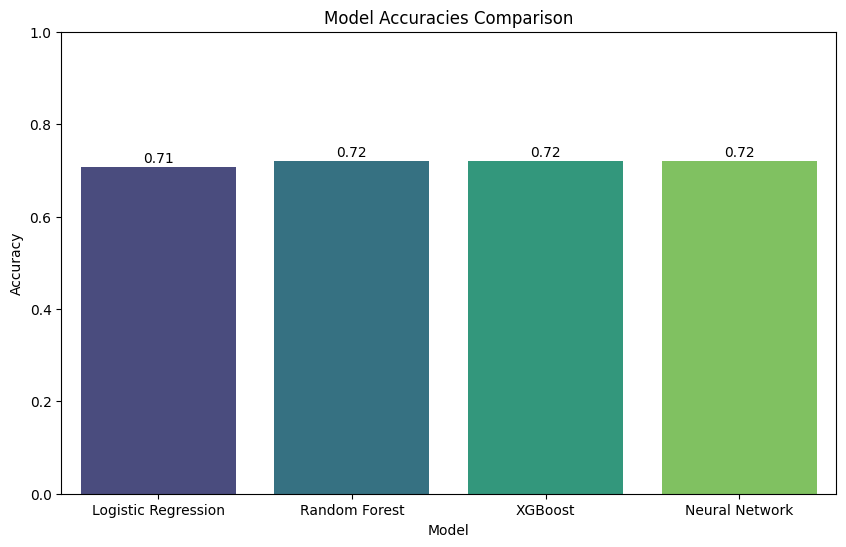

In [18]:
# Visualize the model accuracies
plt.figure(figsize=(10,6))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette='viridis')
plt.title('Model Accuracies Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0,1)
for index, value in enumerate(model_accuracies.values()):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.show()



Confusion Matrix:


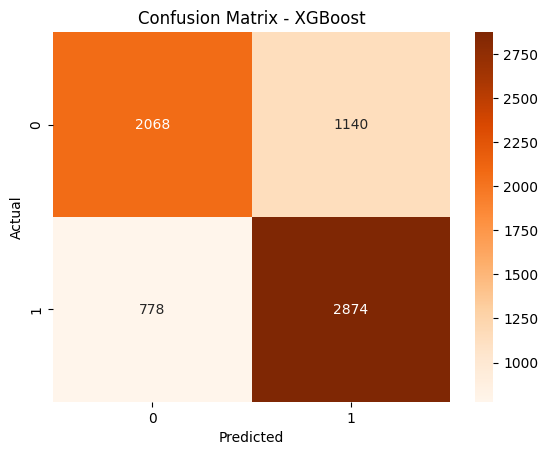


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      3208
           1       0.72      0.79      0.75      3652

    accuracy                           0.72      6860
   macro avg       0.72      0.72      0.72      6860
weighted avg       0.72      0.72      0.72      6860



In [19]:
# Detailed evaluation of the best model
if best_model_name == 'Neural Network':
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_nn)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Neural Network')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_nn))
elif best_model_name == 'Random Forest':
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_rf)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title('Confusion Matrix - Random Forest')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_rf))
elif best_model_name == 'XGBoost':
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_xgb)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title('Confusion Matrix - XGBoost')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb))
elif best_model_name == 'Logistic Regression':
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_lr)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.title('Confusion Matrix - Logistic Regression')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_lr))
